In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore")

## 1) Mehodological Overview:

In this notebook I will try to make a step by step overview of my thought process throughout resolving this assignment. Before preceding with this modeling notebook I initially done an extensive EDA on the data. Many assumptions in this notebook are based on observations that were uncovered during the EDA process.

#### Overview:
- One of the main observation from the EDA is that the Compute Usage data has an increasing trend an possibly seasonality. 
- Taking this into account I proceeded to plot the "classical decomposition" of the "ComputeUsage" feature.
- I analyzed the seasonality decomposition and observed an interesting pattern throughout the week day (more datils in that chapter)
- Taking into consideration that the data Compute Usage has a positive trend and also that we observe some intuitive seasonal pattern from the decomposition, the Holt-Winters methodology was chosen for our forecast
- Because Holt-Winters works with non-stationary time series, there is no need for data preprocessing such as stationarization etc.
- For train/test I opted to do a simple time-based split
- For the model's hyperparameter tunning I went with a gridsearch approach since the hyperparameter search space was small
- After finding the optimal parameters I retrained the model and plotted the out of sample forecast

*The process described above are detailed in the below chapters*



## 2) Data Preparation:

In this first part of the notebook, I will prepare the data for modeling.

Steps in data processing:
1) Read the data from CSV to a pandas dataframe
2) Transform string date to datetime format, correct misspelling in customer name column
3) Filter the top 3 customers by usage (top 3 customers usage observed in EDA) 
4) Aggregation of ComputeUsage by Region and Date

In [2]:
# Reading input data
data_path = os.path.abspath(os.path.join(os.path.abspath(""), '..', 'data'))
df = pd.read_csv(f'{data_path}/usageData.csv')

# Data preparation
df['Date'] = pd.to_datetime(df['Date'])
df['CustomerName'] = df['CustomerName'].str.replace('CustomberB','CustomerB')

# Keep the top 3 customers based on computation usage
keep_list = ['CustomerA', 'CustomerB', 'CustomerC']
df = df[df['CustomerName'].isin(keep_list)].reset_index(drop=True)

# Aggregating data at regional level
df = df.groupby(['Date', 'Region'])['ComputeUsage'].agg('sum').reset_index()
df = df.sort_values(['Region', 'Date'])
unq_regions = df['Region'].unique()
print(unq_regions)

#display(df)

['AUSTRALIA EAST' 'EAST US' 'EAST US 2' 'NORTH EUROPE' 'SOUTH CENTRAL US'
 'SOUTHEAST ASIA' 'UK SOUTH' 'WEST EUROPE' 'WEST US 2']


In [3]:
#Check for time gaps
lag_days = (df.groupby('Region')['Date']
                .diff()
                .dt.days
                .fillna(1))
print(f'Min day diff: {min(lag_days)}, Max day diff: {max(lag_days)}')

Min day diff: 1.0, Max day diff: 1.0


The min/max difference between dates are 1 day, meaning that we do not have any historical gaps in the time series.
It is also known from EDA that we do not have any other missing values in the dataset.
<br> No other type of imputation is needed (missing value imputation or interpolation).

## 3) Train/Test split

Because this is a time series problem, we have to be careful not to split the dataset by simple random sampling. Random sampling the dataset will result in data leakage. 
<br>
<br> I opted to do a simple time based train/test split, where I keep all observation earlier than 2021-08-08 in the training set, and observation older than the cut-off that in the Test set, this will ensure we do not have data leakage (eg. using information from the future in the forecast)
<br>
<br> Remark: Due to the small historical span of the dataset I opted not create a validation dataset (used for hyperparameter tunning and model decision making). Although a validation set is a very important step in the model selection process, I think that for this particular simplified use case this will not pose any kind of problem. The hyperparameter space, model complexity and degrees of freedom of the methodologies used in this notebook are verry low, and it is unprobeable that we will overfit the test set.


In [4]:
#Train/Test split
train_cutoff = df['Date'].max() - pd.Timedelta(14, "d")
print(f'Test cutoff from: {train_cutoff}')

df_train = df[df['Date'] <= train_cutoff].reset_index(drop=True)
df_test = df[df['Date'] > train_cutoff].reset_index(drop=True)

Test cutoff from: 2021-08-08 00:00:00+00:00


## 4) Decomposition Analysis

From the EDA it was observed that the "ComputeUsage" feature has a high positive trend and also possibly has some seasonality.

Before deciding on the forecasting methodology, I want to plot the "classical decomposition" of the "ComputeUsage" feature. I will be particularly interested in the seasonal component is any interpretable pattern can be observed.

I will run the decomposition on the 'SOUTH CENTRAL US' region series since we know from EDA that this is by far the region with the highest computation usage.

Remark: There are commonly three types of time series patterns: trend, seasonality and cycles. The "classical decomposition" is a simple methodology that splits the data into just two components: trend-cycle (sometimes called the trend for simplicity) and seasonal.


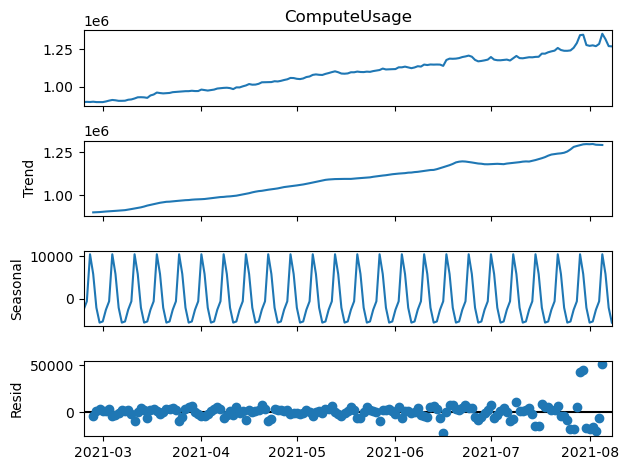

In [5]:
df_aux = df_train[df_train['Region'] == 'SOUTH CENTRAL US']
df_aux.index = pd.to_datetime(df_aux['Date'])

decomposition_plot_multi = seasonal_decompose(df_aux['ComputeUsage'],
                                              model='aditive')

decomposition_plot_multi.plot()
plt.show()

We can observe in the above plot the trend and sesaonal estimated components toghether with the residual plot. The Seasonal pattern loks promesing, I will next plot it and try to understand if sesonal pattern makes intuitive sence.

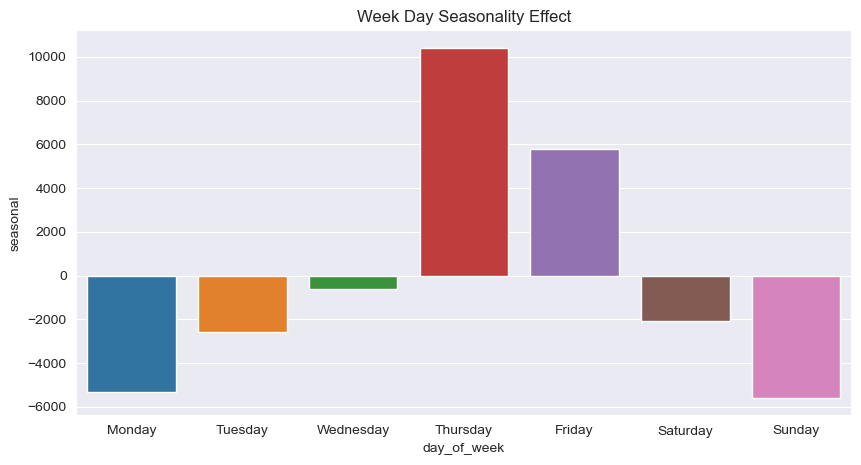

In [6]:
#The day of the week with Monday=0, Sunday=6
weekday_map = {0: 'Monday',
               1: 'Tuesday',
               2: 'Wednesday',
               3: 'Thursday',
               4: 'Friday',
               5: 'Saturday',
               6: 'Sunday'}

season_values = decomposition_plot_multi.seasonal.head(7)
season_values = season_values.to_frame().reset_index()
season_values['day_of_week'] = season_values['Date'].dt.dayofweek
season_values.drop(columns = ['Date'],  inplace=True)
season_values.sort_values('day_of_week', inplace=True)
season_values = season_values.replace({"day_of_week": weekday_map})

sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(season_values, x="day_of_week", y="seasonal")
plt.title("Week Day Seasonality Effect")
plt.show()

- The above plot shows the impact of each week's day seasonality in the final decomposition.
- We can observe that Sunday and Monday tend to have a highly negative impact, meaning that generally in these two days we observe lower resource usage.
- On the other hand, Thursday and Friday have a high positive impact on resource usage.
- From my point of view this seasonality pattern makes sense, we have lower usage in the weekend and Monday. I believe Monday has such high negative impact because on Monday morning (12AM to ~10AM) the usage is verry low.


## 5) Forecasting Methodology

Taking into consideration what we know by now, namely the the data Compute Usage has a positive trend and also that we observe some intuitive seasonal pattern from the decomposition, I think a forecasting methodology that will leverage those two particularity of our dataset will be appropriate.

Holt-Winters’ seasonal method is a forecasting methodology from the "Exponential Smoothing" family. This method comprises the forecast equation and three smoothing equations — one for the level ℓt, one for the trend bt, and one for the seasonal component st.

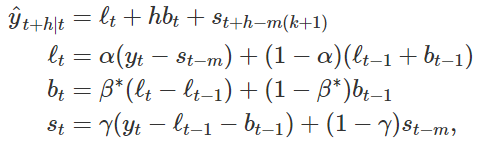

The Holt-Winters model will leverage what we already know about our time series (the observed positive trend and the seasonality). Also, there are other prose of using this method:
1) Simple model with low degrees of freedom (hard to overfit)
2) Low training data requirements
3) Low number of hyperparameters
3) Works with non-stationary data
4) No need for much data preprocessing (no need for stationarities, normalization etc.)

## 6) Model Training and Hyperparameter tunning

In this chapter of the notebook, we will define a hyperparameter tunning function that will take as input the train and test data, together with the hyperparameter search space and will return the most optimal model in terms of validation metric.

The function loops through the hyperparameter search space in a grid search fashion and trains a model for each region separately. After all regions are trained it will calculate the evaluation metric on the full validation population (on all regions) and return the metric.

The evaluation metric I chose for model selection is the 'Mean Absolute Percentage Error" (MAPE). This method is preferred in this scenario because it is not dependent on the prediction's scale (since usage scales are different across regions, MAPE will not be affected)

In [7]:

def exponential_smoothing_hyper_tunning(df_train, df_test, unq_regions, params_grid, fcast_steps):

    print(f'Hyperparameter space consistis in {len(params_grid)} parameter combinations.')
    search_results = {}
    for params in params_grid:
        print(f'\n Training with params:  {params}')

        for reg in unq_regions:

            df_aux = df_train[df_train['Region'] == reg]
            df_aux.index = pd.to_datetime(df_aux['Date'])

            # Fit Holt Winters model and get forecasts
            model = ExponentialSmoothing(df_aux['ComputeUsage'], freq='D', trend=params['trend'],
                                        seasonal=params['seasonal'], seasonal_periods=7) \
                                        .fit(optimized=True)

            model_fcast = model.forecast(fcast_steps)
            df_test.loc[df_test['Region'] == reg ,'prediction'] = model_fcast.values

            print(f'    Training region {reg}: Done')

        mape = mean_absolute_percentage_error(df_test['ComputeUsage'], df_test['prediction'])
        print(f'\n Mean Absolute Error:  {mape}')
        search_results[mape] = params

    return search_results
    
def get_optimal_hyper(search_results):
    return search_results[min(search_results.keys())]


params_grid = list(ParameterGrid({"trend": ["add", 'mul', None],
                                  "seasonal": ["add", 'mul', None]}))

search_results = exponential_smoothing_hyper_tunning(df_train, df_test, unq_regions, params_grid, 14)
optim_params = get_optimal_hyper(search_results)
print(f'\n Optimal parameters found: {optim_params}')
print(f'\n Optimal model has a MAPE of {min(search_results.keys())} on the validation sample')

Hyperparameter space consistis in 9 parameter combinations.

 Training with params:  {'seasonal': 'add', 'trend': 'add'}
    Training region AUSTRALIA EAST: Done
    Training region EAST US: Done
    Training region EAST US 2: Done
    Training region NORTH EUROPE: Done
    Training region SOUTH CENTRAL US: Done
    Training region SOUTHEAST ASIA: Done
    Training region UK SOUTH: Done
    Training region WEST EUROPE: Done
    Training region WEST US 2: Done

 Mean Absolute Error:  0.03366851098424704

 Training with params:  {'seasonal': 'add', 'trend': 'mul'}
    Training region AUSTRALIA EAST: Done
    Training region EAST US: Done
    Training region EAST US 2: Done
    Training region NORTH EUROPE: Done
    Training region SOUTH CENTRAL US: Done
    Training region SOUTHEAST ASIA: Done
    Training region UK SOUTH: Done
    Training region WEST EUROPE: Done
    Training region WEST US 2: Done

 Mean Absolute Error:  0.03530099867971617

 Training with params:  {'seasonal': 'add',

The result of the hyperparameter tunning shows that the best model in terms of validation metric is a Holt-Winters aditive model with both a trend and a sesonal component ({'seasonal': 'add', 'trend': 'add'}).

The average MAPE across all regions for this model is around 3%, meaning that on average this model's prediction are 3% off the actual values.

## 7) Final Model Retraining and Forecasting

In this chapter we will retrain the models (one for each region) with the optimal parameters found in the previons step.
Also we will visualize the forecast vs the true values from the test sample.

In [12]:
def plot_func_plotly(train, test, forecast, title):
    """Function to plot the forecasts using Plotly."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['ComputeUsage'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['ComputeUsage'], mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecast, mode='lines', name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Compute Usage')
    return fig.show()

def plot_func_mat(train, test, forecast, title):
    """Function to plot the forecasts using Matplotlib."""
    plt.figure(figsize=(10, 5))

    # Plot train data
    plt.plot(train['Date'], train['ComputeUsage'], label='Train')

    # Plot test data
    plt.plot(test['Date'], test['ComputeUsage'], label='Test')

    # Plot forecast data
    plt.plot(test['Date'], forecast, label='Forecast')

    # Customize the plot
    plt.title(title, fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Compute Usage', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

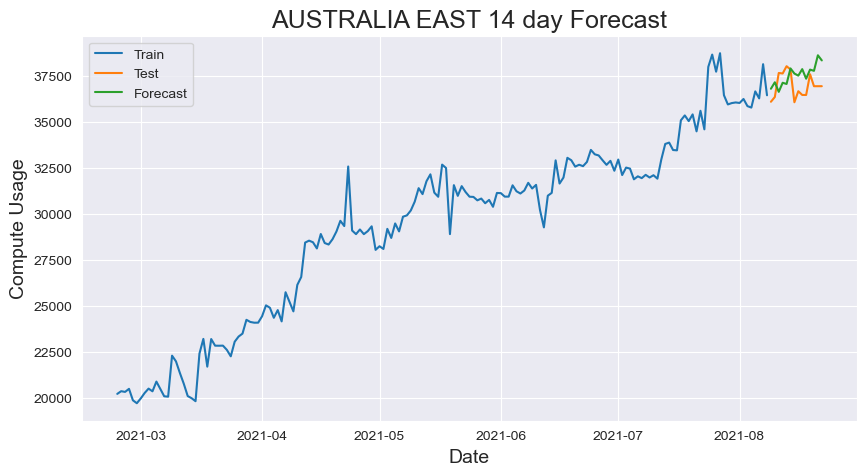

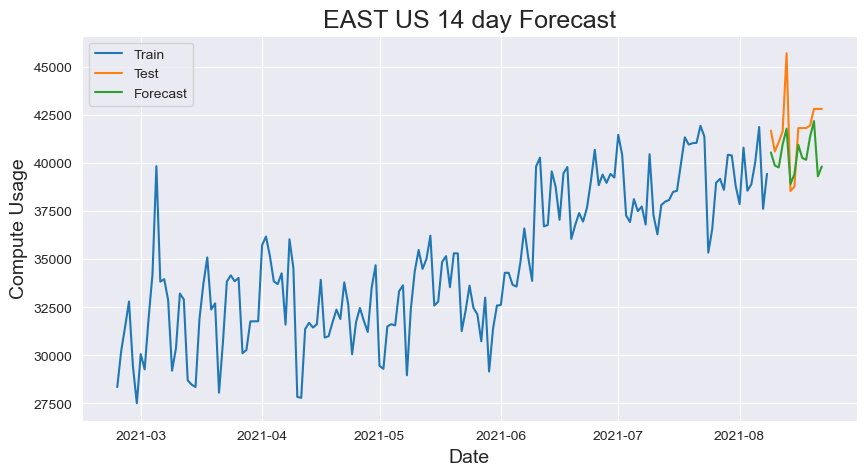

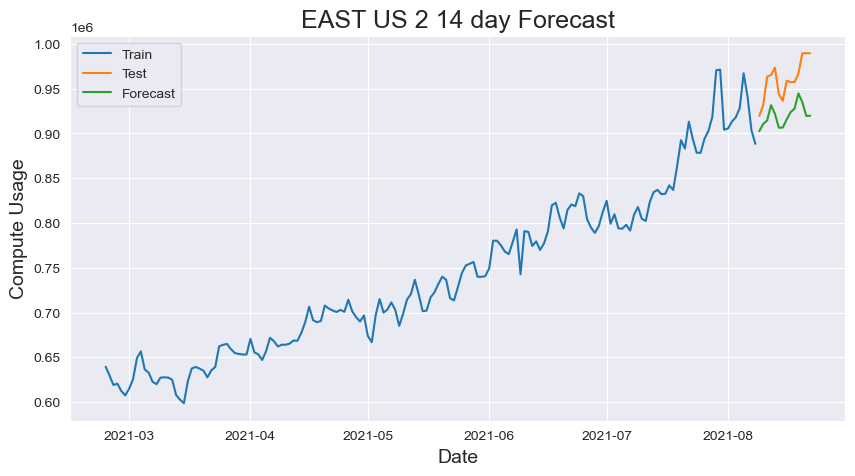

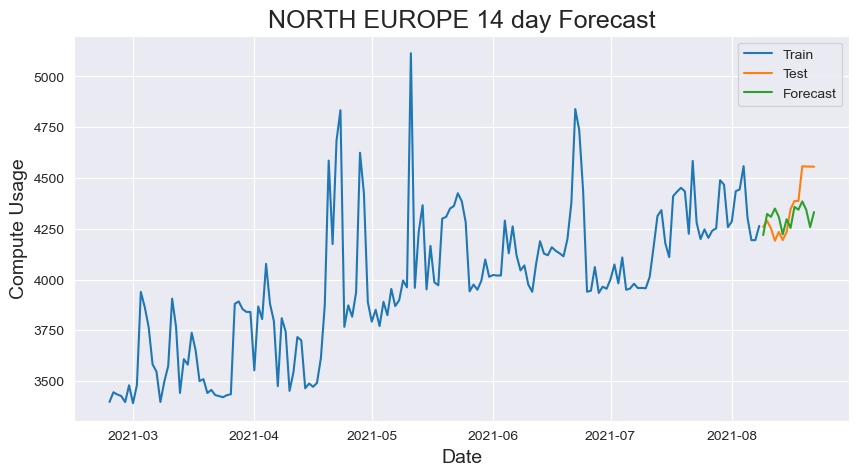

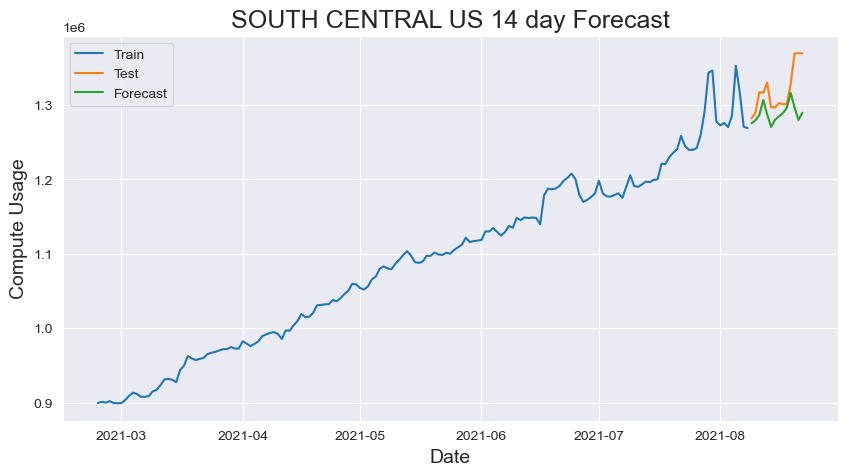

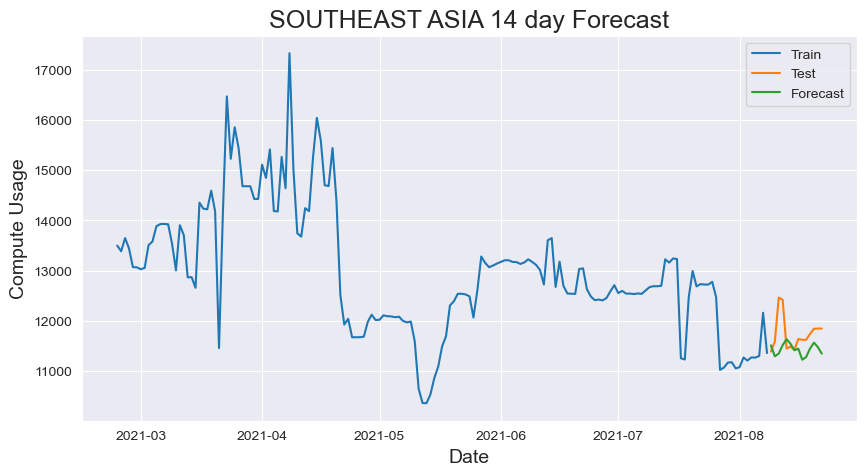

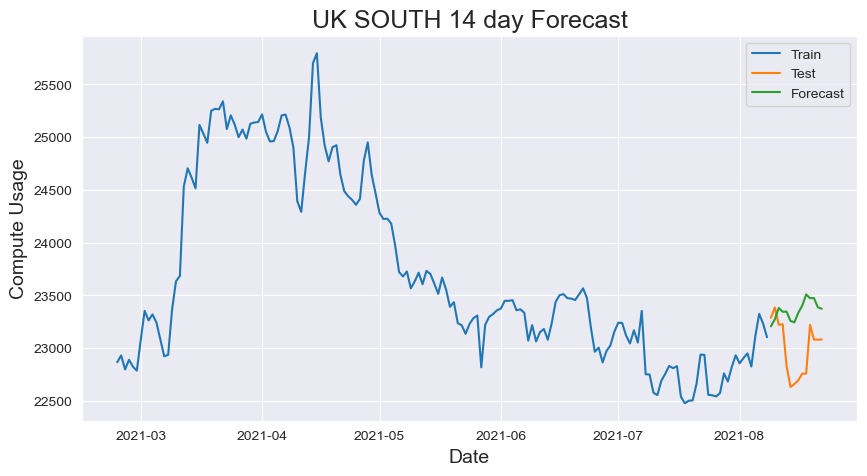

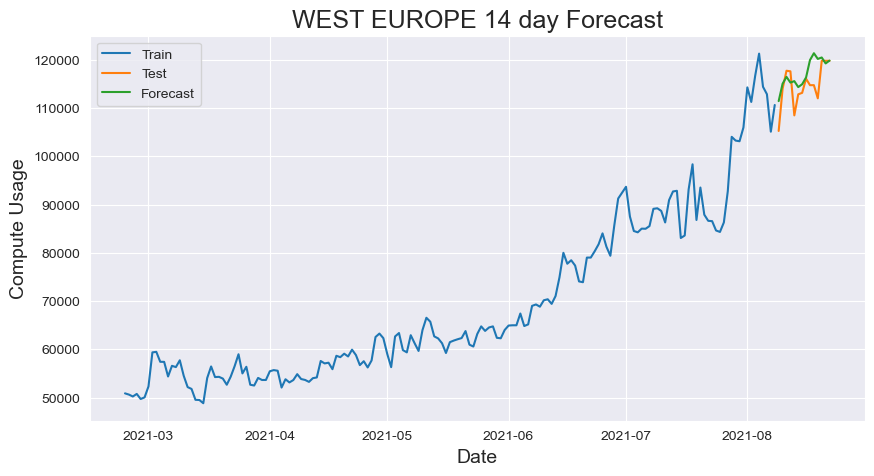

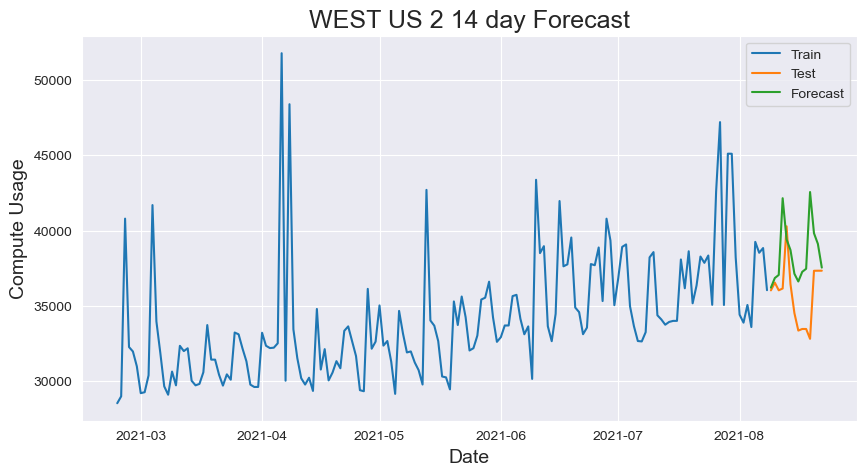

In [13]:
# Retrain model with the optimal parameters and vizualize the forecsat
def train_viz_optim_model(df_train, df_test, unq_regions, optim_params, fcast_steps):
        for reg in unq_regions:

                df_aux = df_train[df_train['Region'] == reg]
                df_aux.index = pd.to_datetime(df_aux['Date'])

                model = ExponentialSmoothing(df_aux['ComputeUsage'], freq='D', trend=optim_params['trend'],
                                        seasonal=optim_params['seasonal'], seasonal_periods=7) \
                                        .fit(optimized=True)

                model_fcast = model.forecast(fcast_steps)

                plot_func_mat(df_train[df_train['Region'] == reg], df_test[df_test['Region'] == reg], model_fcast, f'{reg} {fcast_steps} day Forecast')

train_viz_optim_model(df_train, df_test, unq_regions, optim_params, 14)

## 8) Uncertanty Quantifications

Because of time constrains I could not address the uncertainty problem, but I want to say a few words on how I would approach this problem.

One down side of the Holt-Winters methodology is that is has no direct way of estimating the prediction uncertainty, so we have to analyze other uncertainty methods. One method that should work for this task is the "Out of sample forecast error distribution" method. 

Steps for Out of sample forecast error distribution:

1) Take an out of sample (out of time) dataset (can probably be the validation set)
2) Recursively forecast at each point n steps into the future
3) Calculate the forecast error (difference between true value and prediction) for each point
4) Create a distribution of the forecast errors
5) Use this forecast error distribution to build the confidence bands by taking the n'th desired percentile



## 9) Posible Improvements and Conclusions

#### Improvements:
- Due to time constrains not all possible forecasting univariate methodologies were considered, ARIMA, VAR etc.
- With more features and more other doors may open to other more complex methodologies like decision trees, gradient boosting and RNNs
- The approach I used is a top down approach, meaning that I chose to model the aggregated series. A bottom-up approach can also be considered, where we first model the series for each customer/subscription separately and after we aggregate the results
- The main assumption of this approach was that the weekly seasonal feature made intuitive sense and is statistically significant, I would consider a deeper analysis to be sure that this holds true or not
- The test sample I used is rather small and the results may be affected by variability

#### Conclusions:
- Holt Winters method is can be a good choice when modeling non-stationary time series
- I think that this solution is elegant through it's simplicity, there is no need for complex data preprocessing such as stationarization, standardization etc.
- The model seems to have decent accuracy (3% MAPE) and is better than the naive solution (simple smoothing)
